In [17]:
import os
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
from IPython.display import Image, display

In [18]:
def rgba_to_hex(rgba_tuple):
    if rgba_tuple is None:
        return '#808080'  # Default gray
    r, g, b, a = rgba_tuple
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

def extract_styling_info(symbol_element):
    fill_color = None
    outline_color = None
    line_width = None

    if symbol_element is None:
        print("Warning: `extract_styling_info` received a None symbol element.")
        return fill_color, outline_color, line_width

    # Find the SimpleFill layer and try to extract its properties
    fill_layer = symbol_element.find('.//layer[@class="SimpleFill"]')
    if fill_layer is not None:
        # Check for color defined via an <Option> tag
        color_option = fill_layer.find('Option[@name="color"]')
        if color_option is not None:
            try:
                rgb_parts = [int(p) for p in color_option.get('value').split(',')[:3]]
                fill_color = tuple([p / 255 for p in rgb_parts])
            except (ValueError, TypeError):
                fill_color = None

        # ADDED LOGIC: Check for color defined via a <prop> tag
        if fill_color is None:
            color_prop = fill_layer.find('prop[@k="color"]')
            if color_prop is not None:
                try:
                    rgb_parts = [int(p) for p in color_prop.get('v').split(',')[:3]]
                    fill_color = tuple([p / 255 for p in rgb_parts])
                except (ValueError, TypeError):
                    fill_color = None

        # Extract outline color and width from the fill layer
        outline_option = fill_layer.find('Option[@name="outline_color"]')
        if outline_option is not None:
            try:
                rgb_parts = [int(p) for p in outline_option.get('value').split(',')[:3]]
                outline_color = tuple([p / 255 for p in rgb_parts])
            except (ValueError, TypeError):
                outline_color = None

        width_option = fill_layer.find('Option[@name="outline_width"]')
        if width_option is not None:
            try:
                line_width = float(width_option.get('value'))
            except (ValueError, TypeError):
                line_width = None

    # Find the SimpleLine layer and try to extract its properties
    line_layer = symbol_element.find('.//layer[@class="SimpleLine"]')
    if line_layer is not None:
        # Check for line color and width
        color_option = line_layer.find('Option[@name="line_color"]')
        if color_option is not None:
            try:
                rgb_parts = [int(p) for p in color_option.get('value').split(',')[:3]]
                outline_color = tuple([p / 255 for p in rgb_parts])
            except (ValueError, TypeError):
                outline_color = None

        width_option = line_layer.find('Option[@name="line_width"]')
        if width_option is not None:
            try:
                line_width = float(width_option.get('value'))
            except (ValueError, TypeError):
                line_width = None

    return fill_color, outline_color, line_width

In [19]:
def parse_qml_style(qml_path):
    if not os.path.exists(qml_path):
        print(f"QML file not found: {qml_path}")
        return None
    
    try:
        tree = ET.parse(qml_path)
        root = tree.getroot()
        renderer_element = root.find('.//renderer-v2')
        print(f"Successfully parsed QML file: {qml_path}")


        if renderer_element is None:
            print("No renderer-v2 element found.")
            return None
        
        print(f"Found renderer element with type: {renderer_element.get('type')}")


        renderer_type = renderer_element.get('type')
        style = {'renderer_type': renderer_type}
        symbols = {s.get('name'): s for s in root.findall('.//symbols/symbol')}

        if renderer_type == 'singleSymbol':
            symbol_element = renderer_element.find('.//symbol') or symbols.get(renderer_element.get('symbol'))
            if symbol_element is not None:
                
                color_option = symbol_element.find('.//layer/Option[@name="line_color"]') or symbol_element.find('.//layer/Option[@name="color"]')
                if color_option is not None:
                    color_value = color_option.get('value').split(',')[0:3]
                    rgb_parts = [int(p) for p in color_value]
                    style['color'] = (rgb_parts[0] / 255, rgb_parts[1] / 255, rgb_parts[2] / 255)
                else:
                    
                    color_prop = symbol_element.find('.//prop[@k="color"]')
                    if color_prop is not None:
                        rgb_parts = [int(p) for p in color_prop.get('v').split(',')[:3]]
                        style['color'] = (rgb_parts[0] / 255, rgb_parts[1] / 255, rgb_parts[2] / 255)
                    else:
                        print(f"Warning: Single symbol color not found in {qml_path}.")
                        return None
            else:
                print(f"Warning: Could not find symbol element for singleSymbol in {qml_path}.")
                return None

        elif renderer_type == 'categorizedSymbol':
            style['attribute'] = renderer_element.get('attr')

            print(f"Renderer is categorized. Attribute: {style['attribute']}")

            style['categories'] = []
            for cat in renderer_element.findall('categories/category'):
                symbol_element = cat.find('symbol') or symbols.get(cat.get('symbol'))
                fill_color, outline_color, line_width = extract_styling_info(symbol_element)
                style['categories'].append({
                    'value': cat.get('value'),
                    'label': cat.get('label'),
                    'fill_color': fill_color,
                    'outline_color': outline_color,
                    'line_width': line_width
                })

        elif renderer_type == 'graduatedSymbol':
            style['attribute'] = renderer_element.get('attr')

            print(f"Renderer is graduated. Attribute: {style['attribute']}")

            style['classes'] = []
            for cls in renderer_element.findall('classes/class'):
                symbol_element = cls.find('symbol') or symbols.get(cls.get('symbol'))
                fill_color, outline_color, line_width = extract_styling_info(symbol_element)

                print(f"Class: {cls.get('label')}, Range: {cls.get('lower')} to {cls.get('upper')}, Extracted Fill Color: {fill_color}")
            
                style['classes'].append({
                    'lower_bound': float(cls.get('lower')),
                    'upper_bound': float(cls.get('upper')),
                    'label': cls.get('label'),
                    'fill_color': fill_color,
                    'outline_color': outline_color,
                    'line_width': line_width
                })
        
        elif renderer_type == 'RuleRenderer':
            print(f"Renderer is RuleRenderer. Attribute: {style['attribute']}")
            
            style['rules'] = []
            for rule in renderer_element.findall('.//rule'):
                symbol_element = rule.find('.//symbol')
                fill_color, outline_color, line_width = extract_styling_info(symbol_element)
                style['rules'].append({
                    'filter': rule.get('filter'),
                    'label': rule.get('label'),
                    'fill_color': fill_color,
                    'outline_color': outline_color,
                    'line_width': line_width
                })

        else:
            print(f"Warning: Unsupported renderer type '{renderer_type}'. Using default style.")
            return None
        return style
    except Exception as e:
        print(f"Error parsing QML file {qml_path}: {e}")
        return None

In [20]:
def generate_vector_thumbnail(vector_path, out_path, qml_path):
    try:
        gdf = gpd.read_file(vector_path)
        print(f"Successfully read GeoJSON file. Number of features: {len(gdf)}")

        style_info = parse_qml_style(qml_path)
        print("Style information received from parser:")

        fig, ax = plt.subplots(figsize=(6, 6))
        
        default_fill_color = (0.8, 0.8, 0.8, 1.0) # Light gray
        default_outline_color = (0, 0, 0, 1.0)   # Black
        default_line_width = 1.0

        if style_info is None:
            print("Applying default style due to parsing error.")
            gdf.plot(ax=ax, color=rgba_to_hex(default_fill_color), edgecolor=rgba_to_hex(default_outline_color), linewidth=default_line_width)
        
        elif style_info.get('renderer_type') == 'singleSymbol':
            print("Applying single symbol style...")
            fill_color = style_info.get('fill_color', default_fill_color)
            outline_color = style_info.get('outline_color', default_outline_color)
            line_width = style_info.get('line_width', default_line_width)
            gdf.plot(ax=ax, color=rgba_to_hex(fill_color), edgecolor=rgba_to_hex(outline_color), linewidth=line_width)

        elif style_info.get('renderer_type') == 'categorizedSymbol':
            
            print("Applying categorized style...")
            
            color_map = {
                cat.get('value'): rgba_to_hex(cat.get('fill_color', default_fill_color))
                for cat in style_info.get('categories', [])
            }
            
            outline_color_map = {
                cat.get('value'): rgba_to_hex(cat.get('outline_color', default_outline_color))
                for cat in style_info.get('categories', [])
            }

            attribute_name = style_info.get('attribute')
            print("Categorized renderer detected. Building color map...")
            print(f"Plotting with attribute: {attribute_name}")

            if attribute_name not in gdf.columns:
                print(f"ERROR: Attribute column '{attribute_name}' not found. Check your QML file and GeoJSON data.")
    
                gdf.plot(ax=ax, color=rgba_to_hex(default_fill_color), edgecolor=rgba_to_hex(default_outline_color), linewidth=default_line_width)
            else:
                gdf['mapped_value'] = gdf[attribute_name].apply(lambda x: str(x).strip() if pd.notnull(x) else None)
                
                fill_colors = gdf['mapped_value'].map(color_map)
                fill_colors = fill_colors.fillna(rgba_to_hex(default_fill_color))

                outline_colors = gdf['mapped_value'].map(outline_color_map)
                outline_colors = outline_colors.fillna(rgba_to_hex(default_outline_color))
                
                gdf.plot(ax=ax, color=fill_colors, edgecolor=outline_colors, linewidth=default_line_width)
            

        elif style_info.get('renderer_type') == 'graduatedSymbol':
            print("Applying graduated style...")
            attribute_name = style_info.get('attribute')
            if attribute_name not in gdf.columns:
                print(f"ERROR: Attribute column '{attribute_name}' not found.Check your QML file and GeoJSON data.")
                gdf.plot(ax=ax, color=rgba_to_hex(default_fill_color), edgecolor=rgba_to_hex(default_outline_color), linewidth=default_line_width)
            else:
                fill_colors = []
                sorted_classes = sorted(style_info.get('classes', []), key=lambda cls: float(cls.get('lower', -1e10)))

                for _, row in gdf.iterrows():
                    val = row[attribute_name]
                    found_color = default_fill_color
                    print(f"\nProcessing feature with value: {val}")

                    for i, cls in enumerate(sorted_classes):
                        lower = float(cls.get('lower'))
                        upper = float(cls.get('upper'))

                        
                        if i < len(sorted_classes) - 1:
                            
                            if lower <= val < upper:
                                print(f"-> Match found! Value {val} is between {lower} and {upper}.")
                                found_color = cls.get('fill_color', default_fill_color)
                                break
                        else:
                            
                            if lower <= val <= upper:
                                print(f"-> Match found! Value {val} is between {lower} and {upper}.")
                                found_color = cls.get('fill_color', default_fill_color)
                                break
                    
                    print(f"-> Final color for this feature: {rgba_to_hex(found_color)}")
                    fill_colors.append(rgba_to_hex(found_color))
                    
                gdf.plot(ax=ax, color=fill_colors, edgecolor=rgba_to_hex(default_outline_color), linewidth=default_line_width)
                    

        elif style_info.get('renderer_type') == 'RuleRenderer':
            print("Applying rule-based style...")
            fill_colors = []
            for _, row in gdf.iterrows():
                assigned_color = default_fill_color
                for rule in style_info.get('rules', []):
                    try:
                        attribute_name = rule['filter'].split(' ')[0].strip().strip('"').strip("'")
                        if attribute_name in row and pd.eval(rule['filter'], local_dict={attribute_name: row[attribute_name]}):
                            assigned_color = rule.get('fill_color', default_fill_color)
                            break
                    except Exception:
                        continue  
                fill_colors.append(rgba_to_hex(assigned_color))
            gdf.plot(ax=ax, color=fill_colors, edgecolor=rgba_to_hex(default_outline_color), linewidth=default_line_width)
            

        else:
            print("Applying default blue style.")
            gdf.plot(ax=ax, color='lightblue', edgecolor=rgba_to_hex(default_outline_color), linewidth=default_line_width)

        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close(fig)
        print(f"Thumbnail saved to: {out_path}")

    except Exception as e:
        print(f"Error generating vector thumbnail: {e}")


Successfully read GeoJSON file. Number of features: 57
Successfully parsed QML file: /home/vishnu/corestack_STAC/data/MWS-Well-Depth-18_23.qml
Found renderer element with type: graduatedSymbol
Renderer is graduated. Attribute: Net2018_23
Style information received from parser:
Applying graduated style...

Processing feature with value: -5.525470273132411
-> Final color for this feature: #cccccc

Processing feature with value: -6.0516318313023305
-> Final color for this feature: #cccccc

Processing feature with value: -7.05868677677441
-> Final color for this feature: #cccccc

Processing feature with value: -5.579971206442907
-> Final color for this feature: #cccccc

Processing feature with value: -8.244450792038991
-> Final color for this feature: #cccccc

Processing feature with value: -5.960643831385781
-> Final color for this feature: #cccccc

Processing feature with value: -8.49074374386387
-> Final color for this feature: #cccccc

Processing feature with value: -6.544506358211532


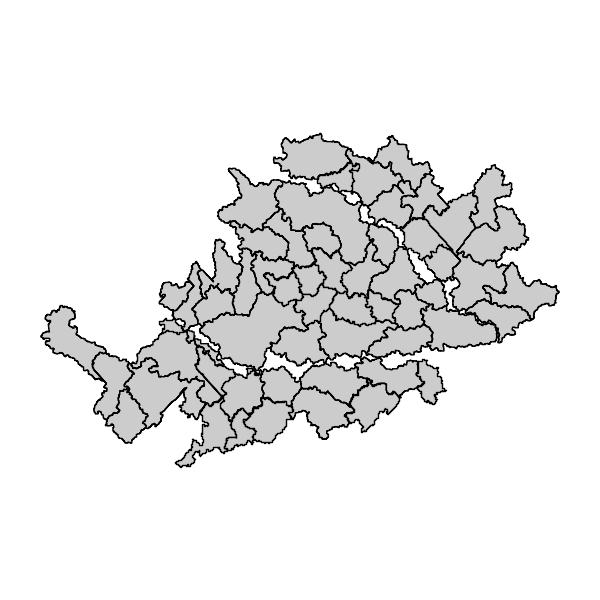

In [22]:
# vector_path = "/home/vishnu/corestack_STAC/data/cropping_intensity_jaunpur_badlapur_2017-23.geojson"
# qml_path = "/home/vishnu/corestack_STAC/data/Cropping_intensity.qml"
# out_path = "/home/vishnu/corestack_STAC/data/cropping_thumbnail.png"

# vector_path = "/home/vishnu/corestack_STAC/data/drought_jaunpur_badlapur_2017_2022.geojson"
# qml_path = "/home/vishnu/corestack_STAC/data/Drought_style.qml"
# out_path = "/home/vishnu/corestack_STAC/data/drought_thumbnail.png"

# vector_path = "/home/vishnu/corestack_STAC/data/admin_boundary_jaunpur_badlapur.geojson"
# qml_path = "/home/vishnu/corestack_STAC/data/Administrative-Boundary-Style.qml"
# out_path = "/home/vishnu/corestack_STAC/data/admin_boundary.png"

vector_path = "/home/vishnu/corestack_STAC/data/well_depth_net_value_jaunpur_badlapur.geojson"
qml_path = "/home/vishnu/corestack_STAC/data/MWS-Well-Depth-18_23.qml"
out_path = "/home/vishnu/corestack_STAC/data/MWS.png"

generate_vector_thumbnail(vector_path, out_path, qml_path)
display(Image(filename=out_path))